In [156]:

import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from PIL import Image
import yaml


def loaddata(show_im=True):
    psf = Image.open(psfname)
    psf = np.array(psf, dtype='float32')
    data = Image.open(imgname)
    data = np.array(data, dtype='float32')
    
    """In the picamera, there is a non-trivial background 
    (even in the dark) that must be subtracted"""
    bg = np.mean(psf[5:15,5:15]) 
    psf -= bg
    data -= bg
    
    """Resize to a more manageable size to do reconstruction on. 
    Because resizing is downsampling, it is subject to aliasing 
    (artifacts produced by the periodic nature of sampling). Demosaicing is an attempt
    to account for/reduce the aliasing caused. In this application, we do the simplest
    possible demosaicing algorithm: smoothing/blurring the image with a box filter"""
    
    def resize(img, factor):
        num = int(-np.log2(factor))
        for i in range(num):
            img = 0.25*(img[::2,::2,...]+img[1::2,::2,...]+img[::2,1::2,...]+img[1::2,1::2,...])
        return img    
    
    psf = resize(psf, f)
    data = resize(data, f)
    
    
    """ nmormalizing copy from shreyas"""
    psf /= np.linalg.norm(psf.ravel())
    data /= np.linalg.norm(data.ravel())
    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')
        plt.show()
        fig2 = plt.figure()
        plt.imshow(data, cmap='gray')
        plt.title('Raw data')
        plt.show()
    return psf, data

def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start

    init_shape = h.shape
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    H = fft.fft2(hpad, norm="ortho")
    Hadj = np.conj(H)

    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    
    return H, Hadj, v, utils

def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    return np.real(calcAHerm(Hadj, diff, pad))

def calcA(H, vk, crop):
    Vk = fft.fft2(vk, norm="ortho")
    return crop(fft.ifftshift(fft.ifft2(H*Vk, norm="ortho")))

def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(xpad, norm="ortho")
    return fft.ifftshift(fft.ifft2(Hadj*X, norm="ortho"))


def grad_descent(h, b):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
        
    alpha = np.real(2/(np.max(Hadj * H)))
    iterations = 0
     
    def non_neg(xi):
        xi = np.maximum(xi,0)
        return xi

    # proj = lambda x: x #Do no projection
    proj = non_neg #Enforce nonnegativity at every gradient step. Comment out as needed.


    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v
    
    
    
    #### uncomment for Nesterov momentum update ####   
    #p = 0
    #mu = 0.9
    ################################################
    
    
    
    #### uncomment for FISTA update ################
    tk = 1
    xk = v
    ################################################
        
    for iterations in range(iters):   
        
        # uncomment for regular GD update
        #vk = gd_update(vk, parent_var)
        
        # uncomment for Nesterov momentum update 
        #vk, p = nesterov_update(vk, p, mu, parent_var)
        
        # uncomment for FISTA update
        vk, tk, xk = fista_update(vk, tk, xk, parent_var)

        if iterations % disp_pic == 0:
            print(iterations)
            image = proj(crop(vk))
            # f = plt.figure(1)
            # plt.imshow(image, cmap='gray')
            # plt.title('Reconstruction after iteration {}'.format(iterations))
            # plt.show()
    
    
    return proj(crop(vk)) 
    
def gd_update(vk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    vk = proj(vk)
    
    return xk    

def nesterov_update(vk, p, mu, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    p_prev = p
    gradient = grad(Hadj, H, vk, b, crop, pad)
    p = mu*p - alpha*gradient
    vk += -mu*p_prev + (1+mu)*p
    vk = proj(vk)
    
    return vk, p

def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    return vk, tk, xk


In [123]:


if __name__ == "__main__":
    ### Reading in params from config file (don't mess with parameter names!)
    params = yaml.full_load(open("gd_config.yml"))
    for k,v in params.items():
        exec(k + "=v")

    psfname = "./tutorial/psf_sample.tif"
    imgname = "./tutorial/rawdata_hand_sample.tif"
        

    f = 0.5 #Downsampling factor (must be decimal, must be 1/2^k where k is positive integer)
    iters = 100 #Number of iterations
    disp_pic = 20 #Number of iterations after which we display intermediate reconstruction
            

    # psf, data = loaddata()


In [132]:
psf = Image.open(psfname)
width, height = psf.size

data = Image.open(imgname)

psf = psf.resize((width//4, height//4))
data = data.resize((width//4, height//4))

psf = np.array(psf, dtype='float32')
data = np.array(data, dtype='float32')

psf /= np.linalg.norm(psf.ravel(), ord=1)
# data /= np.linalg.norm(data.ravel())
    


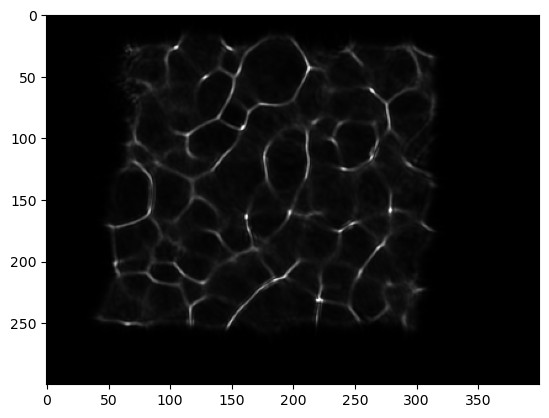

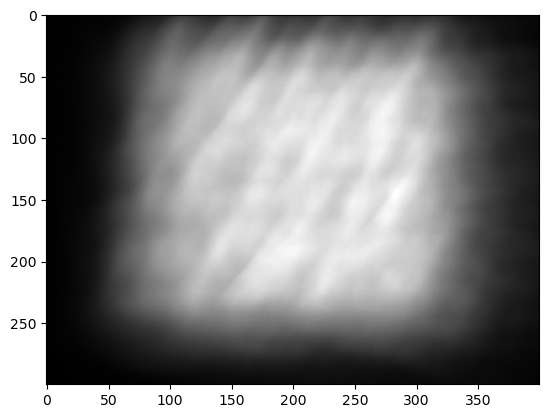

In [133]:
plt.figure()
plt.imshow(psf, cmap='gray')

plt.figure()
plt.imshow(data, cmap='gray')

0
20
40
60
80
100


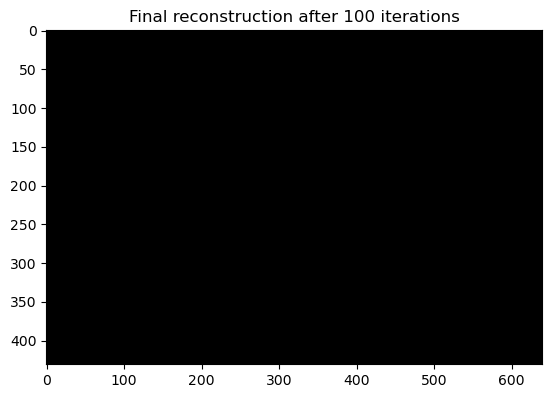

In [157]:

    
final_im = grad_descent(psf, data)
print(iters)

plt.figure()
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstruction after {} iterations'.format(iters))
plt.show()


In [66]:
# image = Image.fromarray(final_im)
# image = image.convert('RGB')
# image.save('result.jpg')


In [136]:
final_im.max()

467764260.0

In [151]:
psf_rgb = np.load('test_images/sample1_sgm5_psf.npy')
# width, height = psf.size

data_rgb = Image.open('test_images/sample1_sgm5.jpg')
data_rgb = np.array(data_rgb)
data_reconstructed = np.zeros_like(data_rgb)


In [152]:
data_rgb.max()

253

In [139]:
# for i in range(3):
#     psf = psf_rgb[:,:,i]
#     data = data_rgb[:,:,i]

In [153]:
psf = psf_rgb[:,:,0]
data = data_rgb[:,:,0]

psf = np.array(psf, dtype='float32')
data = np.array(data, dtype='float32')

psf /= np.linalg.norm(psf.ravel(), ord=1)
# data /= np.linalg.norm(data.ravel())


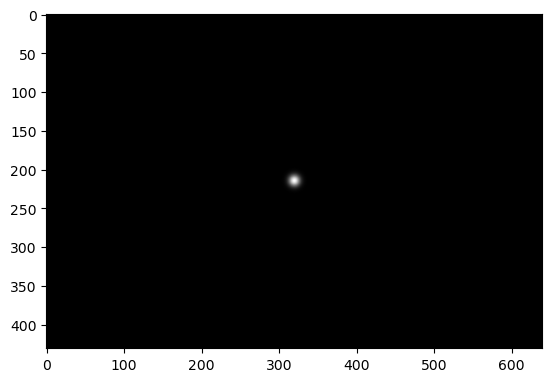

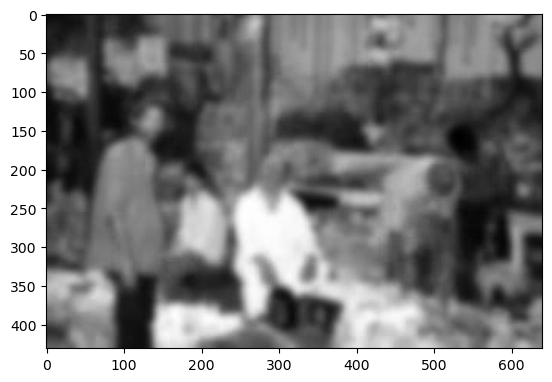

In [154]:
plt.figure()
plt.imshow(psf, cmap='gray')
plt.show()

plt.figure()
plt.imshow(data, cmap='gray')
plt.show()

0
20
40
60
80


c:\ProgramData\Anaconda3\envs\torch182\lib\site-packages\ipykernel_launcher.py:182: RuntimeWarning: overflow encountered in add
c:\ProgramData\Anaconda3\envs\torch182\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in multiply


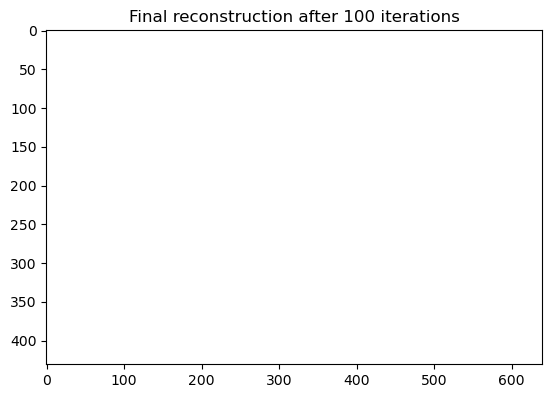

In [155]:

final_im = grad_descent(psf, data)

plt.figure()
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstruction after {} iterations'.format(iters))
plt.show()


In [121]:
final_im.min()


0.0

In [ ]:

psf = psf.resize((width//4, height//4))
data = data.resize((width//4, height//4))

psf = np.array(psf, dtype='float32')
data = np.array(data, dtype='float32')

psf /= np.linalg.norm(psf.ravel(), ord=1)
data /= np.linalg.norm(data.ravel())